# Model Development: Credit-Score
<img src="../assets/credit-pic.jpg" alt="Title-Pic">

# Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from pandas import Series, DataFrame
from datetime import datetime
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score


np.set_printoptions(suppress=True)
sns.set(rc={"figure.figsize": (10, 6), "axes.titlesize": 20, "axes.titleweight": "bold", "axes.labelsize": 15})

# Data

In [5]:
MODEL_DATA = np.load("../model_data/credit_score_prep_data.npz", allow_pickle=True)
X_train = MODEL_DATA["inputs"]
y_train = MODEL_DATA["targets"]

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=101)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=101)

(X_train.shape, X_test.shape, X_val.shape), (y_train.shape, y_test.shape, y_val.shape)

(((127608, 45), (15951, 45), (15951, 45)), ((127608,), (15951,), (15951,)))

# Helper Functions

In [6]:
def export_model(model, model_name):
    timestamp_string = str(datetime.now())[:19].replace(" ", "").replace(":", "").replace("-", "")
    export_path = f"../trained_models/{timestamp_string}_{model_name}"
    with open(export_path, "wb") as model_file:
        pickle.dump(model, model_file)
    
    return export_path

In [7]:
def load_model(model_path):
    with open(model_path, "rb") as model_file:
        return pickle.load(model_file)

In [8]:
def top_rankings(cv_results, top=10):
    sorted_zipped_report = sorted(
        zip(
            cv_results["params"], 
            cv_results["mean_test_score"], 
            cv_results["rank_test_score"]
        ), key=lambda item: item[2]
    )
    for (i, (params, score, rank)) in enumerate(sorted_zipped_report):
        if i >= top:
            break

        print(f"Rank: {rank}\tScore: {score}\nParam: {params}\n")
        

In [9]:
def model_classification_report(model, X_data, y_data):
    preds_test = model.predict(X_data)
    preds_train = model.predict(X_train)

    f1_score_test = f1_score(y_data, preds_test, average="macro")
    accuracy_score_test = accuracy_score(y_data, preds_test)
    f1_score_train = f1_score(y_train, preds_train, average="macro")
    accuracy_score_train = accuracy_score(y_train, preds_train)

    print(f"Accuracy:\t{f1_score_test}\t|\tTrain-Accuracy:\t{accuracy_score_train}")
    print(f"F1-Score:\t{accuracy_score_test}\t|\tTrain-F1-Score:\t{f1_score_train}\n")
    print(classification_report(y_data, preds_test))

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_data, preds_test), annot=True, cmap="cool", fmt='.5g')


# Build the Model

## Model1: GradientBoost Model

In [10]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

Accuracy:	0.8031489835073541	|	Train-Accuracy:	0.8399630117234029
F1-Score:	0.804024826029716	|	Train-F1-Score:	0.8389128026813858

              precision    recall  f1-score   support

           0       0.82      0.78      0.80      5310
           1       0.80      0.73      0.77      5420
           2       0.79      0.90      0.84      5221

    accuracy                           0.80     15951
   macro avg       0.81      0.81      0.80     15951
weighted avg       0.81      0.80      0.80     15951



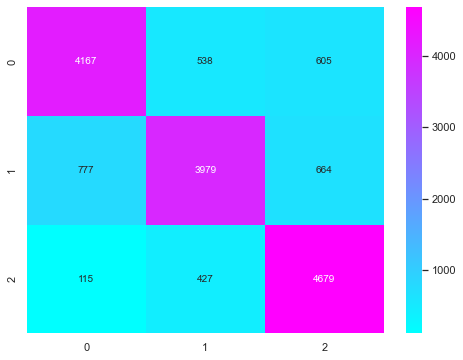

In [11]:
model_classification_report(xgb_model, X_test, y_test)

## Model2: K-Nearest-Neighbor KNN

In [12]:
knn_model = KNeighborsClassifier(3)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

Accuracy:	0.8563248190962272	|	Train-Accuracy:	0.9194642969092847
F1-Score:	0.8624537646542536	|	Train-F1-Score:	0.9168534457617469

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      5310
           1       0.93      0.65      0.76      5420
           2       0.86      0.98      0.91      5221

    accuracy                           0.86     15951
   macro avg       0.87      0.86      0.86     15951
weighted avg       0.87      0.86      0.86     15951



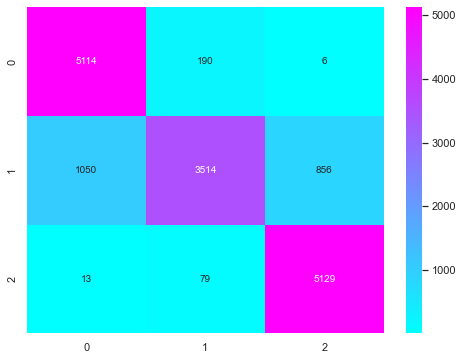

In [13]:
model_classification_report(knn_model, X_test, y_test)

## Model3: RandomForest

In [14]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier()

Accuracy:	0.8819336514767562	|	Train-Accuracy:	0.9999843270014419
F1-Score:	0.8831421227509247	|	Train-F1-Score:	0.9999843228452295

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      5310
           1       0.90      0.77      0.83      5420
           2       0.89      0.95      0.92      5221

    accuracy                           0.88     15951
   macro avg       0.88      0.88      0.88     15951
weighted avg       0.88      0.88      0.88     15951



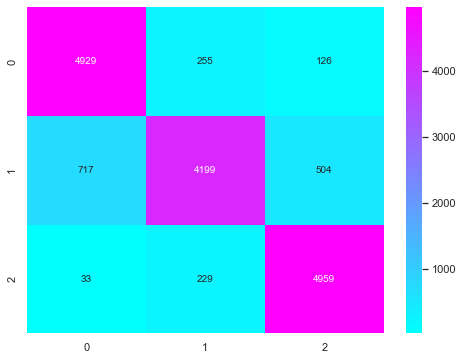

In [15]:
model_classification_report(rf_model, X_test, y_test)

## Model4: Decision Tree

In [16]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

Accuracy:	0.7926236681497403	|	Train-Accuracy:	1.0
F1-Score:	0.7922387311140368	|	Train-F1-Score:	1.0

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      5310
           1       0.74      0.73      0.73      5420
           2       0.84      0.85      0.84      5221

    accuracy                           0.79     15951
   macro avg       0.79      0.79      0.79     15951
weighted avg       0.79      0.79      0.79     15951



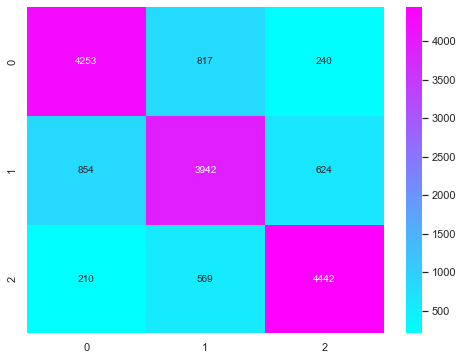

In [17]:
model_classification_report(dt_model, X_test, y_test)

## Model6: Voting Classifier

In [18]:
estimators_c1 = [
    ("rf", rf_model),
    ("knn", knn_model),
    ("xgb", xgb_model),
    ("dt", dt_model)
]

estimators_c2 = [
    ("rf", rf_model),
    ("knn", knn_model),
    ("xgb", xgb_model),
]

estimators_c3 = [
    ("rf", rf_model),
    ("knn", knn_model),
]



In [19]:
vc_model1 = VotingClassifier(estimators=estimators_c1, voting="soft")
vc_model2 = VotingClassifier(estimators=estimators_c2, voting="soft")
vc_model3 = VotingClassifier(estimators=estimators_c3, voting="soft")
vc_model4 = VotingClassifier(estimators=estimators_c1, voting="hard")
vc_model5 = VotingClassifier(estimators=estimators_c2, voting="hard")
vc_model6 = VotingClassifier(estimators=estimators_c3, voting="hard")

vc_model1.fit(X_train, y_train)
vc_model2.fit(X_train, y_train)
vc_model3.fit(X_train, y_train);

Accuracy:	0.8784224713375095	|	Train-Accuracy:	0.9999764905021629
F1-Score:	0.8796940630681462	|	Train-F1-Score:	0.9999764846832271

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      5310
           1       0.89      0.77      0.82      5420
           2       0.89      0.95      0.92      5221

    accuracy                           0.88     15951
   macro avg       0.88      0.88      0.88     15951
weighted avg       0.88      0.88      0.88     15951



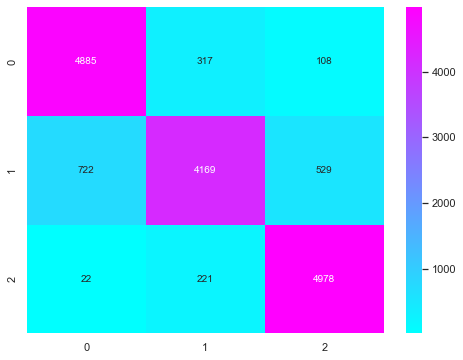

In [20]:
model_classification_report(vc_model1, X_test, y_test)

Accuracy:	0.8885823779062507	|	Train-Accuracy:	0.9628549934173406
F1-Score:	0.8913547739953608	|	Train-F1-Score:	0.9623734767644931

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      5310
           1       0.94      0.74      0.83      5420
           2       0.89      0.98      0.93      5221

    accuracy                           0.89     15951
   macro avg       0.90      0.89      0.89     15951
weighted avg       0.90      0.89      0.89     15951



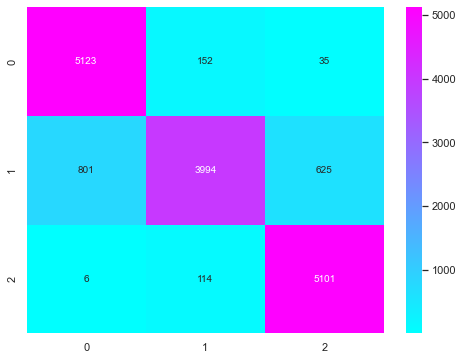

In [21]:
model_classification_report(vc_model2, X_test, y_test)

Accuracy:	0.8800561373563474	|	Train-Accuracy:	0.9894834179675256
F1-Score:	0.8838317346874804	|	Train-F1-Score:	0.9894449033610169

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      5310
           1       0.94      0.71      0.81      5420
           2       0.88      0.98      0.93      5221

    accuracy                           0.88     15951
   macro avg       0.89      0.89      0.88     15951
weighted avg       0.89      0.88      0.88     15951



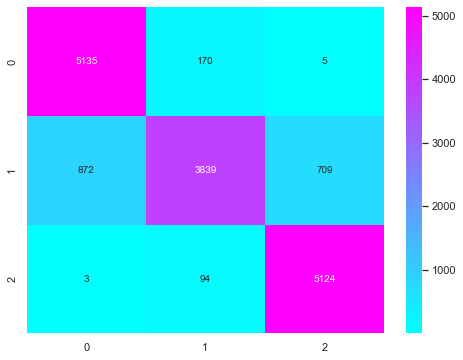

In [22]:
model_classification_report(vc_model3, X_test, y_test)

In [26]:
vc_model = vc_model2
vc_model

VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('knn', KNeighborsClassifier(n_neighbors=3)),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_bin=256, max_cat_to_onehot=4,
                                            max_delta_step=0, max_depth=6,
                                            max_leaves=0, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=0,
                                            num_parallel_tree=1,
                                            objective='multi:softprob',
                                            predictor='auto', random_state=0,
                                            reg_alpha=0, ...))],
                 voting='soft')

## Mode7: Stacking Classifier

In [27]:
sc_model = StackingClassifier(estimators_c2, final_estimator=vc_model)
sc_model.fit(X_train, y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier()),
                               ('knn', KNeighborsClassifier(n_neighbors=3)),
                               ('xgb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None, gamma=0,
                                              gpu_id=-1,
                                              grow_policy='depthwise',
                                              import...
                                                                               grow_policy='depthwise',
                                                                               importance_type=None,
                                                                               interaction_constraints='',
                                                                               learning_rate=0.300000012,
                                                                               max_bin=256,
                                                                               max_cat_to_onehot=4,
                                                                               max_delta_step=0,
                                                                               max_depth=6,
                                                                               max_leaves=0,
                                                                               min_child_weight=1,
                                                                               missing=nan,
                                                                               monotone_constraints='()',
                                                                               n_estimators=100,
                                                                               n_jobs=0,
                                                                               num_parallel_tree=1,
                                                                               objective='multi:softprob',
                                                                               predictor='auto',
                                                                               random_state=0,
                                                                               reg_alpha=0, ...))],
                                                    voting='soft'))

Accuracy:	0.8958264881019687	|	Train-Accuracy:	0.981929032662529
F1-Score:	0.8972478214532005	|	Train-F1-Score:	0.9818575867812999

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      5310
           1       0.91      0.78      0.84      5420
           2       0.91      0.96      0.94      5221

    accuracy                           0.90     15951
   macro avg       0.90      0.90      0.90     15951
weighted avg       0.90      0.90      0.90     15951



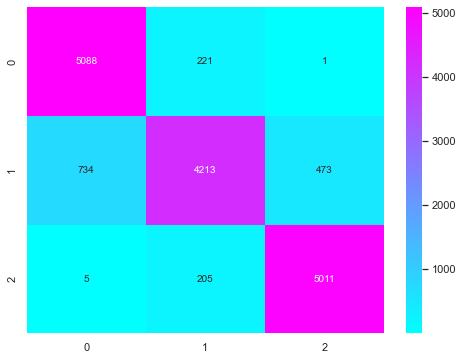

In [28]:
model_classification_report(sc_model, X_test, y_test)

# Final Model Selection

Accuracy:	0.8880865304589848	|	Train-Accuracy:	0.963113597893549
F1-Score:	0.8922951539088458	|	Train-F1-Score:	0.9626411177437211

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      5300
           1       0.94      0.73      0.82      5258
           2       0.89      0.98      0.93      5393

    accuracy                           0.89     15951
   macro avg       0.90      0.89      0.89     15951
weighted avg       0.90      0.89      0.89     15951



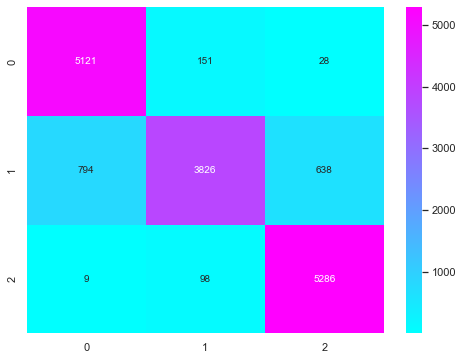

In [23]:
model_classification_report(vc_model, X_val, y_val)

Accuracy:	0.8965196246552621	|	Train-Accuracy:	0.9800325998370009
F1-Score:	0.8989405052974735	|	Train-F1-Score:	0.9799402114146161

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      5300
           1       0.90      0.78      0.84      5258
           2       0.92      0.96      0.94      5393

    accuracy                           0.90     15951
   macro avg       0.90      0.90      0.90     15951
weighted avg       0.90      0.90      0.90     15951



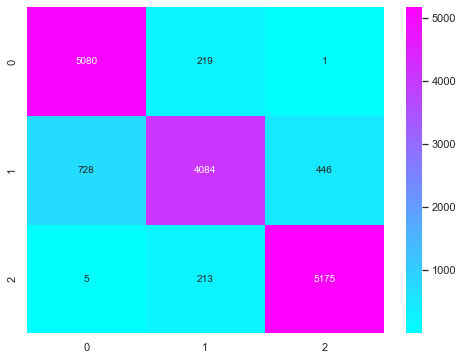

In [24]:
model_classification_report(sc_model, X_val, y_val)

In [25]:
final_model = vc_model
final_model

VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('knn', KNeighborsClassifier(n_neighbors=3)),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_bin=256, max_cat_to_onehot=4,
                                            max_delta_step=0, max_depth=6,
                                            max_leaves=0, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=0,
                                            num_parallel_tree=1,
                                            objective='multi:softprob',
                                            predictor='auto', random_state=0,
                                            reg_alpha=0, ...))],
                 voting='soft')

# Export the Model

In [26]:
model_path = export_model(final_model, "model_credit_score_classifier")

Accuracy:	0.8880865304589848	|	Train-Accuracy:	0.963113597893549
F1-Score:	0.8922951539088458	|	Train-F1-Score:	0.9626411177437211

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      5300
           1       0.94      0.73      0.82      5258
           2       0.89      0.98      0.93      5393

    accuracy                           0.89     15951
   macro avg       0.90      0.89      0.89     15951
weighted avg       0.90      0.89      0.89     15951



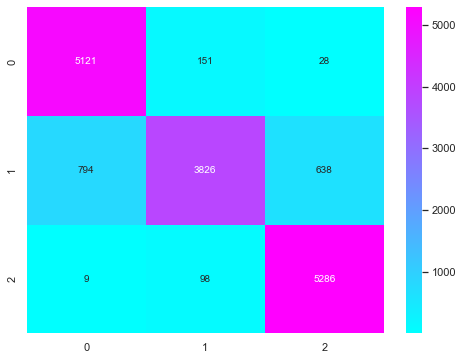

In [27]:
loaded_model = load_model(model_path)
model_classification_report(loaded_model, X_val, y_val)